# 读取图片

In [1]:
from PIL import Image
import requests
from io import BytesIO
import pylab
url = 'https://vignette.wikia.nocookie.net/sonicpokemon/images/b/b2/Psyduck_AG_anime.png'
url='https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2581001411,2979053450&fm=26&gp=0.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
pylab.imshow(img)
pylab.show()

<Figure size 640x480 with 1 Axes>

# 提取轮廓

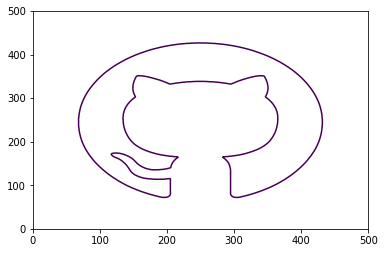

In [2]:
img = img.convert('L')  # 变成灰度

# 找到轮廓
fig, ax = pylab.subplots()
contours = ax.contour(img, origin='image', levels=[100]) 
pylab.show()

# 轮廓去重

In [3]:
import numpy as np

raw_data=np.concatenate(contours.allsegs[0])/ max(img.width, img.height)
print(f'{len(raw_data)} points in raw data')

# 近似到千分位
data=(raw_data*500//1)/500

# 去重
data=np.unique(data,axis=0)

# indices = np.random.choice(len(data), int(len(data) * 0.3), replace=False)
# samples = np.array(data)[indices]
samples=data
print('原始数据{}，近似去重后数据{}，采样后数据{}'.format(len(raw_data),len(data),len(samples)))
# print(f'randomly sampled {len(samples)} points')

2635 points in raw data
原始数据2635，近似去重后数据1921，采样后数据1921


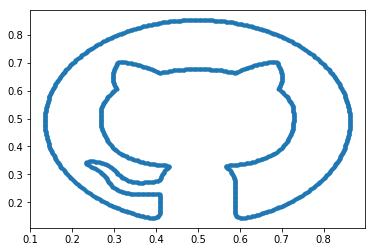

In [4]:
import matplotlib.pyplot as plt
plt.plot(samples[:,0],samples[:,1],'.')

step1:Delaunay 三角剖分

step2:三角剖分后，做最小生成树

In [5]:
import numpy as np
from scipy.spatial import Delaunay
import heapq

def dis(samples, i, j):
        return np.linalg.norm(samples[i] - samples[j])

def mst(samples):
        n = len(samples)
        tri = Delaunay(samples)
        g = [[] for i in range(n)]
        edges = {}
        nodes = set()
        for simplex in tri.simplices:
            nodes |= set(simplex)
            for k in range(3):
                i, j = simplex[k - 1], simplex[k]
                edge = min(i, j), max(i, j)
                if edge not in edges:
                    edges[edge] = dis(samples, i, j)
        pq = [(d, i, j) for ((i, j), d) in edges.items()]
        heapq.heapify(pq)
        p = list(range(n))

        def union(i, j):
            p[find(i)] = find(j)

        def find(i):
            if p[i] == i:
                return i
            p[i] = find(p[i])
            return p[i]

        # Kruskal
        cc = len(nodes)
        while cc > 1:
            d, i, j = heapq.heappop(pq)
            if find(i) != find(j):
                union(i, j)
                g[i].append((j, d))
                g[j].append((i, d))
                cc -= 1
        return g

g = mst(samples)
print(f'Generated minimum spanning tree with {len(g)} nodes.')

Generated minimum spanning tree with 1921 nodes.


In [6]:
# 找到最远的两个点作为起始点

In [7]:
def find_farthest_leaf_pair(g):
    def dfs(i, parent):
        """
        Return
            - farthest leaf id in thissubtree and distance to root i
            - farthest leave pair in this subtree and distance between them
        """
        farthest_leaf = i
        farthest_leaf_dis = 0
        farthest_leaf_pair = None
        farthest_leaf_pair_dis = -1
        leave_dis = []
        for j, _ in g[i]:
            if j == parent:
                continue
            l, ld, pair, pair_dis = dfs(j, i)
            leave_dis.append((ld + 1, l))
            if ld + 1 > farthest_leaf_dis:
                farthest_leaf_dis = ld + 1
                farthest_leaf = l
            if farthest_leaf_pair_dis < pair_dis:
                farthest_leaf_pair = pair
                farthest_leaf_pair_dis = pair_dis
        if len(leave_dis) >= 2:
            (d1, l1), (d2, l2) = sorted(leave_dis)[-2:]
            if d1 + d2 > farthest_leaf_pair_dis:
                farthest_leaf_pair_dis = d1 + d2
                farthest_leaf_pair = l1, l2
        return farthest_leaf, farthest_leaf_dis, farthest_leaf_pair, farthest_leaf_pair_dis

    for i in range(len(g)):
        if len(g[i]):
            l, ld, pair, pair_dis = dfs(i, -1)
            if len(g[i]) == 1 and ld > pair_dis:
                return i, l
            return pair

st, ed = find_farthest_leaf_pair(g)
print(f'Find the farthest leaves pair {samples[st]} {samples[ed]}')

Find the farthest leaves pair [0.86  0.522] [0.862 0.52 ]


In [8]:
def rearange_children_order(g, st, ed):
    vis = set()

    def dfs(i):
        vis.add(i)
        if i == ed:
            return True
        for j in range(len(g[i])):
            if g[i][j][0] not in vis:
                if dfs(g[i][j][0]):
                    g[i][j], g[i][-1] = g[i][-1], g[i][j]
                    return True
        return False
    dfs(st)
    return st, ed
rearange_children_order(g, st, ed)
print('MST children reordered')

MST children reordered


In [9]:
def generate_path(g, st, ed):
    res = []
    vis = set()

    def dfs(i):
        vis.add(i)
        res.append(samples[i])
        if i == ed:
            return True
        leaf = True
        for j, _ in g[i]:
            if j not in vis:
                leaf = False
                if dfs(j):
                    return True
        if not leaf:
            res.append(samples[i])
        return False
    dfs(st)
    return res

path = generate_path(g, st, ed)
print(f'generated path of {len(path)} points')

generated path of 1921 points


In [10]:
from math import sqrt
from functools import partial
import numpy as np
import sys


def pldist(point, start, end):
    """
    Calculates the distance from ``point`` to the line given
    by the points ``start`` and ``end``.

    :param point: a point
    :type point: numpy array
    :param start: a point of the line
    :type start: numpy array
    :param end: another point of the line
    :type end: numpy array
    """
    if np.all(np.equal(start, end)):
        return np.linalg.norm(point - start)

    return np.divide(
            np.abs(np.linalg.norm(np.cross(end - start, start - point))),
            np.linalg.norm(end - start))


def rdp_rec(M, epsilon, dist=pldist):
    """
    Simplifies a given array of points.

    Recursive version.

    :param M: an array
    :type M: numpy array
    :param epsilon: epsilon in the rdp algorithm
    :type epsilon: float
    :param dist: distance function
    :type dist: function with signature ``f(point, start, end)`` -- see :func:`rdp.pldist`
    """
    dmax = 0.0
    index = -1

    for i in range(1, M.shape[0]):
        d = dist(M[i], M[0], M[-1])

        if d > dmax:
            index = i
            dmax = d

    if dmax > epsilon:
        r1 = rdp_rec(M[:index + 1], epsilon, dist)
        r2 = rdp_rec(M[index:], epsilon, dist)

        return np.vstack((r1[:-1], r2))
    else:
        return np.vstack((M[0], M[-1]))


def _rdp_iter(M, start_index, last_index, epsilon, dist=pldist):
    stk = []
    stk.append([start_index, last_index])
    global_start_index = start_index
    indices = np.ones(last_index - start_index + 1, dtype=bool)

    while stk:
        start_index, last_index = stk.pop()

        dmax = 0.0
        index = start_index

        for i in range(index + 1, last_index):
            if indices[i - global_start_index]:
                d = dist(M[i], M[start_index], M[last_index])
                if d > dmax:
                    index = i
                    dmax = d

        if dmax > epsilon:
            stk.append([start_index, index])
            stk.append([index, last_index])
        else:
            for i in range(start_index + 1, last_index):
                indices[i - global_start_index] = False

    return indices


def rdp_iter(M, epsilon, dist=pldist, return_mask=False):
    """
    Simplifies a given array of points.

    Iterative version.

    :param M: an array
    :type M: numpy array
    :param epsilon: epsilon in the rdp algorithm
    :type epsilon: float
    :param dist: distance function
    :type dist: function with signature ``f(point, start, end)`` -- see :func:`rdp.pldist`
    :param return_mask: return the mask of points to keep instead
    :type return_mask: bool
    """
    mask = _rdp_iter(M, 0, len(M) - 1, epsilon, dist)

    if return_mask:
        return mask

    return M[mask]


def rdp(M, epsilon=0, dist=pldist, algo="iter", return_mask=False):
    """
    Simplifies a given array of points using the Ramer-Douglas-Peucker
    algorithm.

    Example:

    >>> from rdp import rdp
    >>> rdp([[1, 1], [2, 2], [3, 3], [4, 4]])
    [[1, 1], [4, 4]]

    This is a convenience wrapper around both :func:`rdp.rdp_iter` 
    and :func:`rdp.rdp_rec` that detects if the input is a numpy array
    in order to adapt the output accordingly. This means that
    when it is called using a Python list as argument, a Python
    list is returned, and in case of an invocation using a numpy
    array, a NumPy array is returned.

    The parameter ``return_mask=True`` can be used in conjunction
    with ``algo="iter"`` to return only the mask of points to keep. Example:

    >>> from rdp import rdp
    >>> import numpy as np
    >>> arr = np.array([1, 1, 2, 2, 3, 3, 4, 4]).reshape(4, 2)
    >>> arr
    array([[1, 1],
           [2, 2],
           [3, 3],
           [4, 4]])
    >>> mask = rdp(arr, algo="iter", return_mask=True)
    >>> mask
    array([ True, False, False,  True], dtype=bool)
    >>> arr[mask]
    array([[1, 1],
           [4, 4]])

    :param M: a series of points
    :type M: numpy array with shape ``(n,d)`` where ``n`` is the number of points and ``d`` their dimension
    :param epsilon: epsilon in the rdp algorithm
    :type epsilon: float
    :param dist: distance function
    :type dist: function with signature ``f(point, start, end)`` -- see :func:`rdp.pldist`
    :param algo: either ``iter`` for an iterative algorithm or ``rec`` for a recursive algorithm
    :type algo: string
    :param return_mask: return mask instead of simplified array
    :type return_mask: bool
    """

    if algo == "iter":
        algo = partial(rdp_iter, return_mask=return_mask)
    elif algo == "rec":
        if return_mask:
            raise NotImplementedError("return_mask=True not supported with algo=\"rec\"")
        algo = rdp_rec
        
    if "numpy" in str(type(M)):
        return algo(M, epsilon, dist)

    return algo(np.array(M), epsilon, dist).tolist()

def rdp_downsample(path, epsilon):
    before_n = len(path)
    path = rdp(path, epsilon=epsilon)
    after_n = len(path)
    return path

path = rdp_downsample(path, 0.01)
print(f'RDP reduced path to {len(path)} points')

RDP reduced path to 46 points


In [11]:
from fourier_artist.clean_data import get_data_from_func, clean_data
from fourier_artist.draw import draw

In [12]:
path=np.array(path)

In [13]:
X=path[:,0]+1j*path[:,1]

总点数46，过滤后的有效点数14


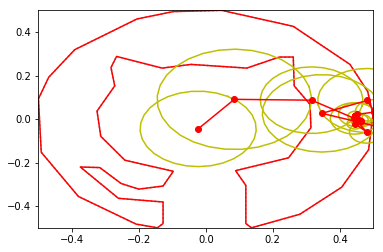

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# 清洗数据
X = clean_data(X)
fig, ax = plt.subplots(1, 1)
update_all = draw(X, fig, ax)
ani = FuncAnimation(fig, update_all, blit=True, interval=500, frames=len(X))
# ani.save('fourier.gif', writer='pillow')
# plt.show()

from IPython.display import HTML
HTML(ani.to_jshtml())